In [2]:
"""
    This algorithm process to the auto-encoding of the images
"""

'\n    This algorithm process to the auto-encoding of the images\n'

In [3]:
from torch.utils.data import DataLoader
from utils.dataset import imageDataset
import pandas as pd

In [4]:
imageDataset

utils.dataset.imageDataset

In [5]:
def get_data(data_folder="./data"):
    """
        Parameters
        ----------
        data_folder: str, folder containing the date

        Return
        ------
        - tuple containing :
            > an image dataset object
            > a pandas dataframe of metadata
        - dataframe of labels
    """

    # Creating an UID
    df_expert = pd.read_csv(f"{data_folder}/mimic-cxr-2.0.0-chexpert.csv.gz")
    df_metadata = pd.read_csv(f"{data_folder}/mimic-cxr-2.0.0-metadata.csv.gz")

    df_metadata = df_metadata.reset_index() \
        .rename(columns = {"index":"uid"}) \
        .drop(columns = ["Unnamed: 0"])

    df_expert = df_expert \
        .drop(columns = ["Unnamed: 0"]) \
        .join(df_metadata[["study_id","uid"]].set_index("study_id"), on = "study_id") \
        .set_index("uid") \
        .sort_index() \
        .reset_index(drop=False)
        
    df_expert["text_label"] = df_expert.iloc[:,3:].apply(
        lambda x: ",".join(x.dropna()[x.dropna() == 1].index.tolist())
    , axis=1)

    # Getting image loader

    ## Getting image path dict
    images_paths = df_metadata[["uid", "subject_id", "dicom_id", "study_id"]] \
                    .reset_index(drop=True)

    images_paths["subject_id_str"] = images_paths["subject_id"].astype("str")
    images_paths["study_id_str"] = images_paths["study_id"].astype("str")

    images_paths["path"] = f"{data_folder}/./files/p"+images_paths["subject_id_str"].str.slice(0,2)+"/p"+ \
        +images_paths["subject_id_str"]+"/s"+ \
        +images_paths["study_id_str"]+"/"+ \
        +images_paths["dicom_id"]+".jpg"

    images_paths = images_paths[["uid","path"]].set_index("uid")["path"] \
            .to_dict()

    ## Loading images
    images_dataset = imageDataset(images_paths)

    return (images_dataset, df_metadata), df_expert

In [6]:
X,y = get_data("./data")

In [7]:
# Splitting train and test
X0_train, X0_test = X[0].split(p=0.7, random_seed=42)

train_id = X0_train.image_list
test_id = X0_test.image_list

X1_train = X[1].set_index("uid").loc[train_id,:].reset_index()
X1_test = X[1].set_index("uid").loc[test_id,:].reset_index()

y_train = y.set_index("uid").loc[train_id,:].reset_index(drop=True)
y_test = y.set_index("uid").loc[test_id,:].reset_index(drop=True)

In [8]:
from torchvision.transforms import RandomResizedCrop, Resize, Normalize
import torch
import numpy as np

In [8]:
def dataset_collater (x):
    
    size = tuple(np.array([x_[0].shape for x_ in x]).min(axis=0).tolist())
    resizer = Resize(512)
    randomcrop = RandomResizedCrop(size=(512,512))
    mean = np.array([0.485, 0.456, 0.406]).mean()
    std = np.array([0.229, 0.224, 0.225]).sum()/np.sqrt(3)
    normalizer = Normalize(mean=mean, std=std)
    
    # Applying randomCrop
    images_tensor = []

    for x_ in x:
        image_tensor = torch.tensor(x_[0], dtype=torch.float32).unsqueeze(dim=0)
        image_tensor = resizer(image_tensor)
        image_tensor = randomcrop(image_tensor)

        images_tensor.append(image_tensor)

    output = torch.stack(images_tensor)
    output = normalizer(output/255.)

    return output

In [9]:
from torch import nn
from torch import optim
from torchvision.models import mobilenet_v3_small

In [10]:
class autoEncoder (nn.Module):

    def __init__ (self):
        super().__init__()

        self.mobilenet = mobilenet_v3_small(pretrained=True)

        self.encoder = nn.Sequential(*[
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(1,1), padding="same"),
            self.mobilenet.features,
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten()
        ])

        self.decoder = nn.Sequential(*[
            nn.Unflatten(1, (1, 24,24)),
            nn.Conv2d(1, 16, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample((48,48)),
            nn.Conv2d(16, 32, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample((96,96)),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample((256,256)),
            nn.Conv2d(64, 128, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample((512,512)),
            nn.Conv2d(128, 1, kernel_size=(3,3), padding="same"),
        ])

        self.loss = nn.MSELoss()
        self.optim = optim.Adam(self.parameters())

    def forward (self, x):
        y_encode = self.encoder(x)

        return y_encode

    def fullpass (self, x):

        y_encode = self(x)
        y_decode = self.decoder(y_encode)

        return y_decode

    def fit (self, x):

        self.train()
        self.optim.zero_grad()
        x_ = self.fullpass(x)
        loss = self.loss(x_, x)

        loss.backward()
        self.optim.step()

        return loss.detach().item()

In [11]:
ae = autoEncoder()
#ae = ae.to("cuda:0")

In [12]:
ae.load_state_dict(torch.load("./models/ae_1.model", map_location="cpu"))

<All keys matched successfully>

In [13]:
dataloader = DataLoader(X0_train, collate_fn=dataset_collater, shuffle=True, batch_size=12)

In [ ]:
n_epoch = 1000

for i in range(n_epoch):
    print(f"Epoch {i}")
    for x in dataloader:
        x = x.to("cuda:0")
        loss = ae.fit(x)

        print(f"Loss value : {loss}")

In [14]:
from matplotlib import pyplot  as plt

In [22]:
i = 2

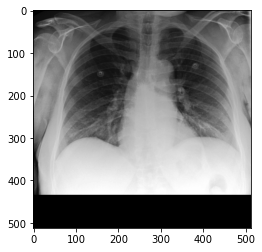

In [29]:
plt.imshow(x[i, 0, :, :].cpu(), cmap="gray")

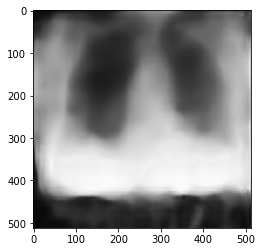

In [30]:
pred = ae.fullpass(x[i, :, :, :].unsqueeze(1))[0, 0, :, :].detach().cpu()
plt.imshow(pred, cmap="gray")

In [ ]:
torch.save(
    ae.state_dict(),
    "./models/ae_1.model"
)

# Getting data projection

In [16]:
dataloader_project = DataLoader(X[0], collate_fn=dataset_collater, shuffle=False, batch_size=64, num_workers=4)

In [18]:
projections = []

for x in dataloader_project:
    print("Processing 64 images")
    y = ae(x)
    y = y.detach()
    projections.append(y)

Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64 images
Processing 64

In [ ]:
projected_data = torch.concat(projections, axis=0).numpy()

In [23]:
import pickle

In [26]:
with open("./data/projected_data.pickle", "wb") as f:
    pickle.dump(projected_data, f)

# K Means

In [28]:
from sklearn.cluster import KMeans

In [29]:
km = KMeans(n_clusters=10)

In [31]:
km.fit(projected_data)

KMeans(n_clusters=10)

In [32]:
clusters = km.predict(projected_data)

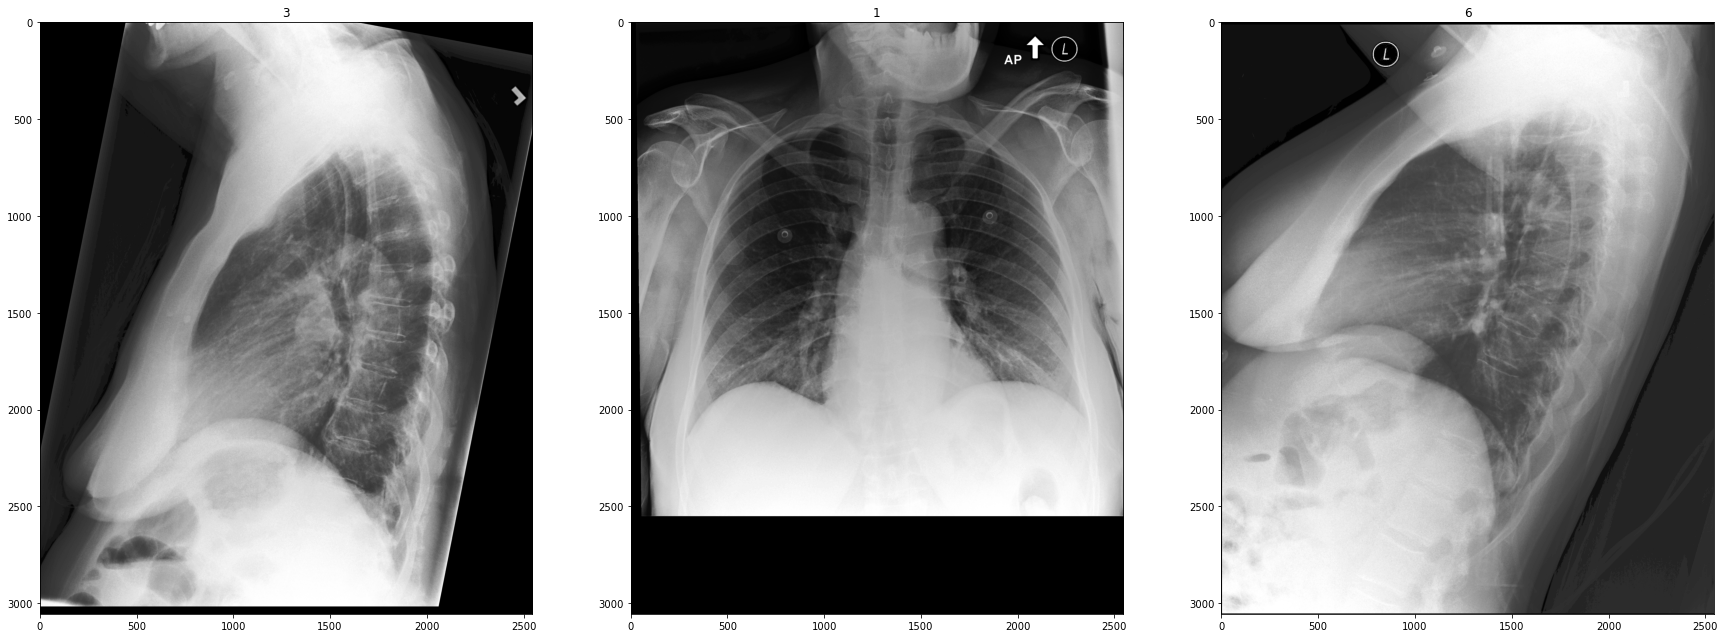

In [37]:
figs, axs = plt.subplots(1,3, figsize=(30,20))
axs = axs.flatten()

start_id = 1
end_id = start_id+3

images = X[0][start_id:end_id]
for (i, j) in zip(range(len(images)), range(start_id, end_id, 1)):
    axs[i].imshow(
        images[i],
        cmap="gray"
    )
    axs[i].set_title(clusters[j])

In [38]:
from sklearn.manifold import TSNE

In [56]:
low_projection = TSNE(n_components=2, perplexity=10).fit_transform(projected_data)

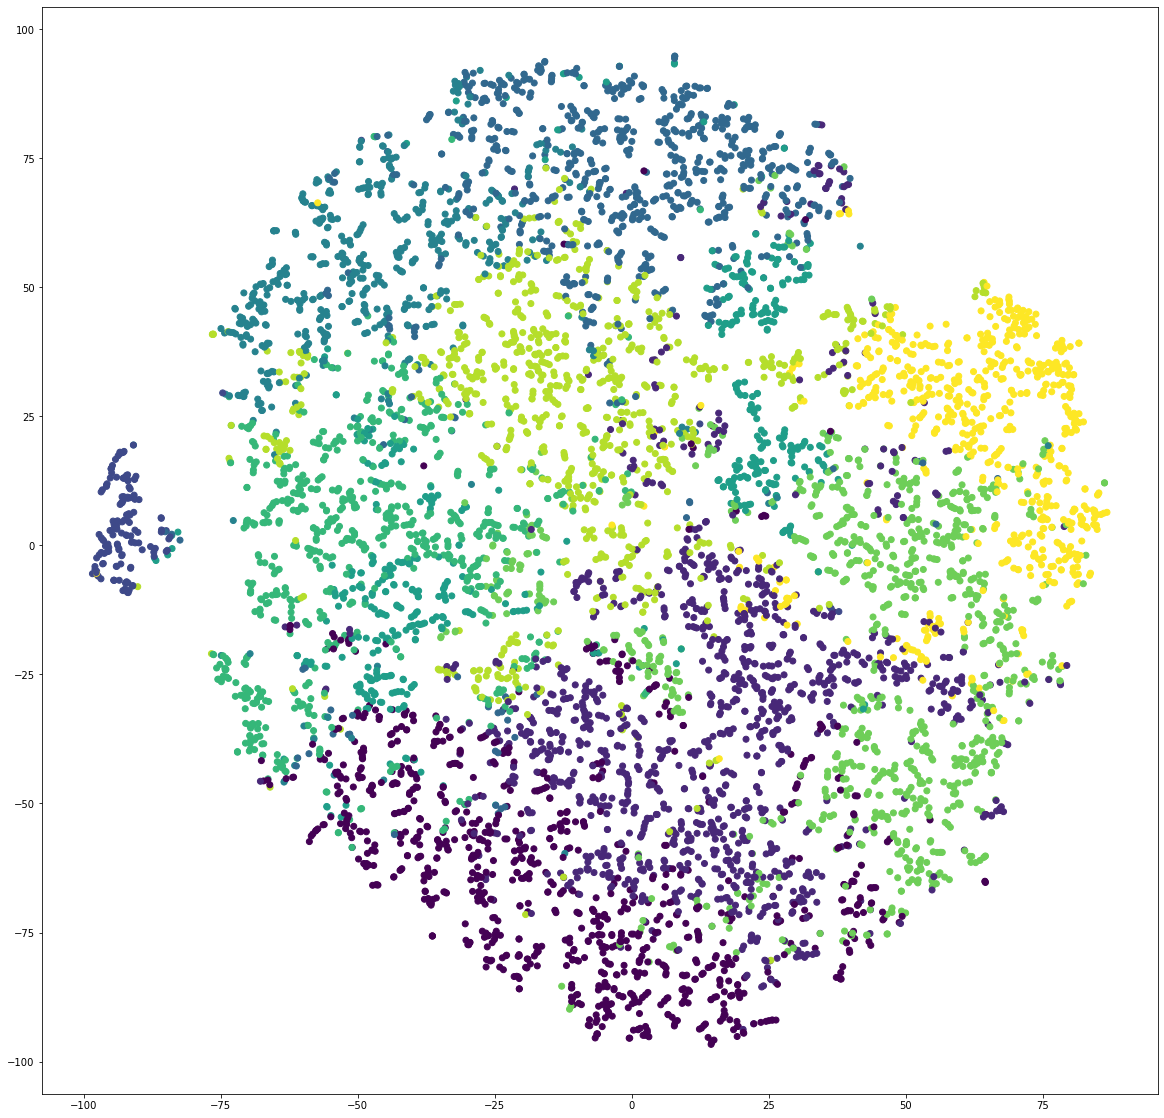

In [57]:
plt.figure(figsize=(20,20))
plt.scatter(
    low_projection[:, 0],
    low_projection[:, 1],
    c=clusters
)

# Reading documents

In [17]:
documents = X[1][["subject_id", "study_id"]].reset_index(drop=True)

In [41]:
subject_id = documents["subject_id"].astype("str")
study_id = documents["study_id"].astype("str")
documents["path"] = "./data/files/p"+subject_id.str.slice(0,2) \
                    +"/p"+subject_id \
                    +"/s"+study_id+".txt"
documents["content"] = documents["path"].apply(lambda x: open(x, "r").read())
documents["impression"] = documents["content"].str.split("IMPRESSION:").apply(lambda x: x[-1]).str.replace("\n","")